# Import libraries 

In [1]:
import pandas as pd
import numpy as np
import time

import sklearn
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# The kernel need not be refreshed if a custom helper file (included in the next cell) is updated
%load_ext autoreload
%autoreload 2
%matplotlib inline
matplotlib.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [2]:
from algorithm_helpers import *
from visualisation_helpers import *

# Load and split the data

In [3]:
path = '../../datasets/vehicles.csv'  # Path to dataset
df = pd.read_csv(path)

In [4]:
df.head()

,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO,Class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus


In [5]:
df.Class.value_counts()

bus     218
saab    217
opel    212
van     199
Name: Class, dtype: int64

Pretty evenly distributed.

In [6]:
X = df.drop(labels='Class', axis=1)  # Drop the target attribute from the X variable
y = df.Class  # The target attribute to be predicted

train_X, test_X, train_y, test_y = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
train_X = (train_X - train_X.mean())/train_X.std()  # Normalize the training data
test_X = (test_X - test_X.mean())/test_X.std()  # Normalize the test data

# Run a classifier and print the confusion matrix

Calibration plot, as we know, makes sense only for binary classification, but this particular dataset has 4 classes. So we **choose any particular class**, make the y values of that class 1 and make the y values of the other 3 classes 0.

To choose our target class, we print the confusion matrix to get an idea of which classes are mostly classified correctly and which are not (for a particular classifier of course).

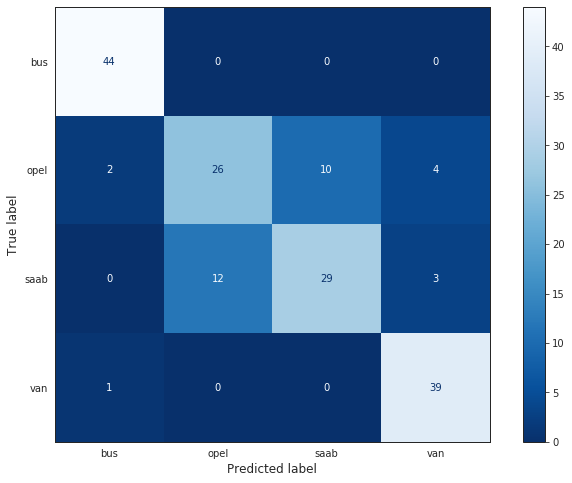

In [7]:
clf = discriminant_analysis.QuadraticDiscriminantAnalysis()
clf.fit(train_X, train_y)
conf = metrics.plot_confusion_matrix(clf, test_X, test_y, cmap=plt.cm.Blues_r)
print(conf)

I tried with a few other classifiers too and the confusion matrix distribution is mostly the same.

Anyway, since **bus** is classified almost correctly and **opel** has a higher misclassification rate, we will study an **opel-vs-all** classifier and then a **bus-vs-all** classifier separately as an extreme case.

# Opel vs all classifier

In [8]:
class_name = 'opel'
test_y_1 = (test_y == class_name)*1
train_y_1 = (train_y == class_name)*1

In [9]:
train_y_1.value_counts()

0    506
1    170
Name: Class, dtype: int64

The class distribution is of course not very well-balanced but will do.

## Calibration curve

### What does it do?

Calibration curve is nothing but the plot of the fraction of true positives against the mean predicted probability for a particular class with respect to a particular classifier.

It should ideally be a straight line angled at 45 degrees, passing through the origin, however, it is not practically observed. It gives us an idea of whether the model is overly confident (above the diagonal) or under-confident (below the diagonal) in its predictions.

### Why do we need it?

For regression tasks, a classifier works by minimizing some kind of a cost function. Since in regression our targets are interval variables, this cost function involves some kind of **distance** between the value predicted and the true value. The same is true for the metrics we use to measure performance, like the R2 score, which is basically quadratically penalized Euclidean distance.

In other words, for a regression task, distance matters and since the distance between two points is intrinsically closely tied to the probability that those two points are **close** to one another, the machine learning algorithms used for regression tend to have reasonably accurate **probability estimates**.

The same is not true for classification as we use all-or-nothing cost functions and metrics. For example, accuracy only measures how often we are correct, and says nothing about how confident we are in being correct. This is because in classification there is intrinsically no such thing as **distance**. This also, however, depends on the classifier used, for example, in **Logistic regression**, the predicted probability is part of the cost function (log loss), but in general it is not applicable to most classifiers.

As a result, most classification algorithms tend to have much weaker and more systematically biased probability prediction forecasts. For settings in which only the class being assigned matters and we do not care about how confident we are in that assignment being correct, this is fine. But if we do care about our confidence, this is a major problem and the model needs some calibration in order to be confident in its prediction.

### Obtain the fraction of true positives and the mean predicted probability

In [10]:
# We use logistic regression as it is somewhat already calibrated because it
# optimizes the log loss which takes into account the predicted probability.
clf = linear_model.LogisticRegression()
clf.fit(train_X, train_y_1)  # Fit on the training data


y_test_predict_proba = clf.predict_proba(test_X)[:, 1]
# Calculate the values from test data
fraction_of_positives, mean_predicted_value = calibration_curve(test_y_1, y_test_predict_proba, n_bins=10)

Here, **n_bins** refers to the number of sections for which we individually sample the values (i.e., *fraction_of_positives* and *mean_predicted_value*).

In [11]:
fraction_of_positives

array([0.04411765, 0.24242424, 0.53846154, 0.25      , 0.38461538,
       0.33333333, 0.57142857, 0.66666667, 0.5       , 0.66666667])

As expected, we get 10 values, one for each section or bin.

In [12]:
mean_predicted_value

array([0.03862229, 0.15157015, 0.25369549, 0.33427793, 0.45366717,
       0.56029257, 0.64545903, 0.75871987, 0.84338059, 0.93034485])

Now we proceed to plot the values to obtain the calibration curve.

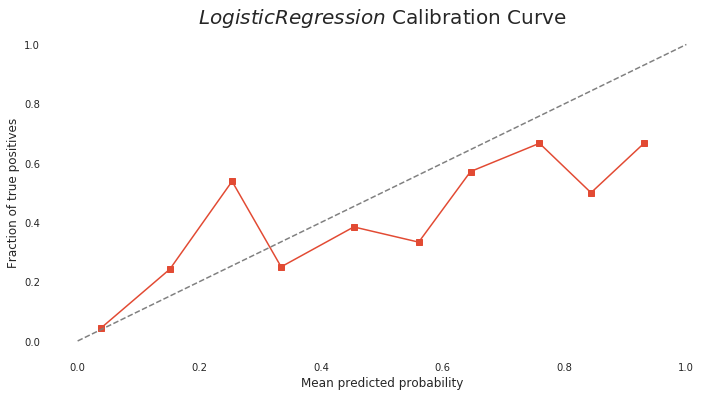

In [13]:
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of true positives")
plt.title("$LogisticRegression$ Calibration Curve", fontsize=20);

Not too well calibrated but not too bad because logistic regression optimizes the prediction probability. Later down below, we will see how non-linear algorithms have largely different calibration curves.

## Calibration

To bring the prediction confidence close to the ratio of actual positives, the classifier can be calibrated. There are mainly two methods for doing it:
* Sigmoid (Platt) - A slight variation of the sigmoid function (with two learnable parameters) is used to fit out the distribution of predicted probabilities to the distribution of probability observed in the training data.
* Isotonic - Piecewise constant non-decreasing function is used and fitted like in linear regression, the slope and intercept of the piecewise lines being learnable. The pairs adjacent violators algorithm is used for this.

### Logistic regression

Uncalibrated Test accuracy: 0.7588235294117647
Calibrated (isotonic) Test accuracy: 0.7588235294117647
Calibrated (sigmoid) Test accuracy: 0.7588235294117647


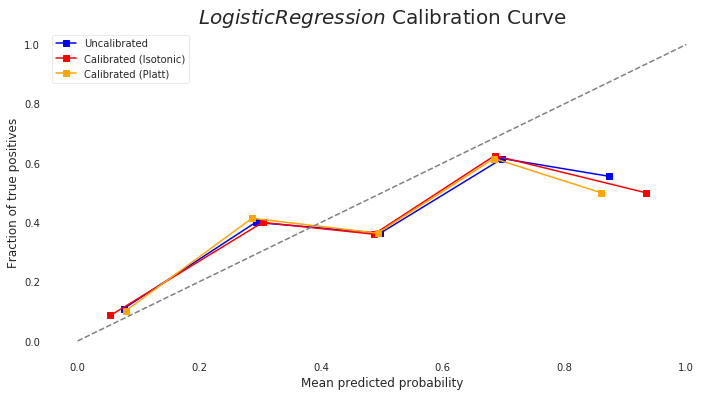

In [14]:
clf = linear_model.LogisticRegression()
clf_isotonic, clf_sigmoid = calibration_plot(clf, train_X, train_y_1, test_X, test_y_1, 5)

As I have already mentioned, logistic regression is by virtue of its own self, fitted aginst prediction probability and hence calibrating it does not help.

### Quadratic discriminant analysis

Uncalibrated Test accuracy: 0.7411764705882353
Calibrated (isotonic) Test accuracy: 0.7588235294117647
Calibrated (sigmoid) Test accuracy: 0.7823529411764706


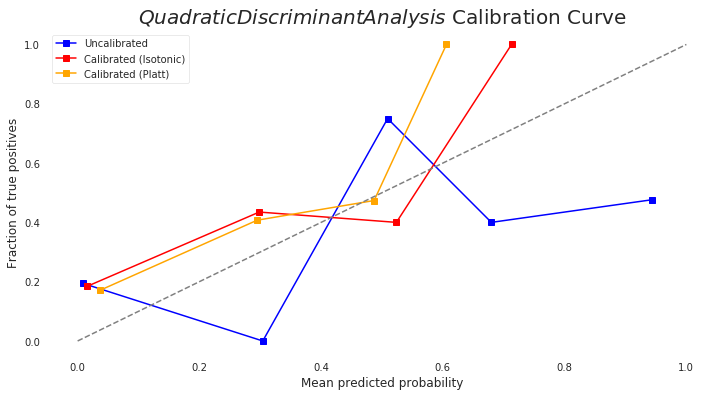

In [15]:
clf = discriminant_analysis.QuadraticDiscriminantAnalysis()
clf_isotonic, clf_sigmoid = calibration_plot(clf, train_X, train_y_1, test_X, test_y_1, 5)

Calibration does help QDA to a great extent. Isotonic calibration seems to work better than sigmoid calibration.

### SVC

The support vector classifier does not provide prediction probabilities by default but we can obtain it by passing ```probability=True``` to the SVC. The probability is generated via bootstrapping, which again is a very expensive process.

Uncalibrated Test accuracy: 0.7764705882352941
Calibrated (isotonic) Test accuracy: 0.7647058823529411
Calibrated (sigmoid) Test accuracy: 0.7705882352941177


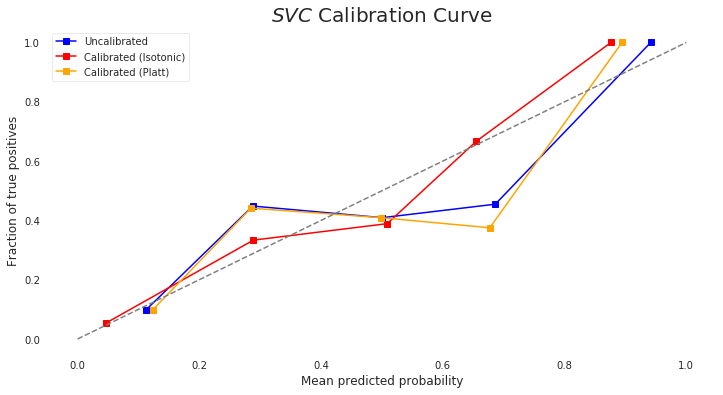

In [16]:
clf = svm.SVC(probability=True)
clf_isotonic, clf_sigmoid = calibration_plot(clf, train_X, train_y_1, test_X, test_y_1, 5)

It is observed that sigmoid calibration does not improve it much, but isotonic calibration does.

### Naive bayes

Uncalibrated Test accuracy: 0.6705882352941176
Calibrated (isotonic) Test accuracy: 0.7529411764705882
Calibrated (sigmoid) Test accuracy: 0.7529411764705882


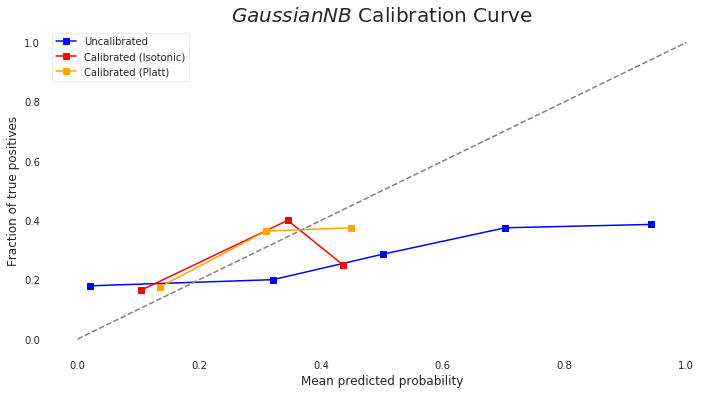

In [17]:
clf = naive_bayes.GaussianNB()
clf_isotonic, clf_sigmoid = calibration_plot(clf, train_X, train_y_1, test_X, test_y_1, 5)

Naive bayes assumes all features to be independent of each other, which is why it gives poor results if there are a lot of redundant features. 

From what I have understood, if we consider *n* axes for *n* features, naive bayes (NB) finds the variance in each axis (or dimension) and its final cluster prediction is a projection of all these variances into the sample space. Hence, with dependant features, the final projection covers a lot more space than the optimum classifier and that pushes boundary points (as predicted by an optimum classifier) more into the central space and increases its prediction probability.

However, since we have as many as 18 features, there is an extremely high probability that any random datapoint lies on the edge of the actual sample space (curse of dimensionality), and as the predicted sample space is as I have said an extension of the actual sample space across each dimension (for naive bayes at least), most of the points lie near (but not on) the predicted gaussian boundary, which causes its predicted probability to be low and stable.

I hope I have been able to explain myself (a diagram would have been better still) and I am actually very satisfied on being able to explain this :D

### Random forest

Uncalibrated Test accuracy: 0.7705882352941177
Calibrated (isotonic) Test accuracy: 0.7764705882352941
Calibrated (sigmoid) Test accuracy: 0.7647058823529411


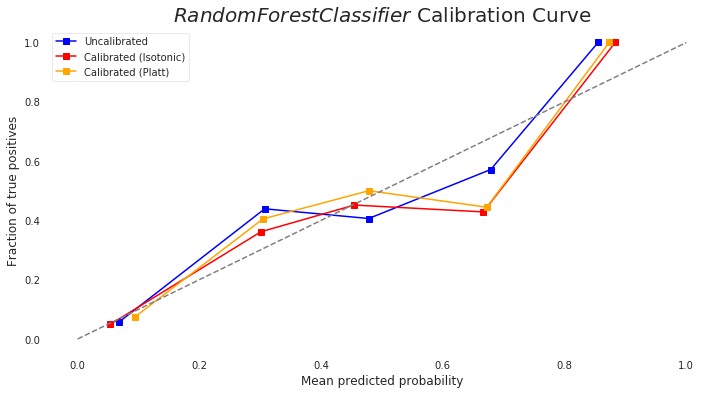

In [18]:
clf = ensemble.RandomForestClassifier()
clf_isotonic, clf_sigmoid = calibration_plot(clf, train_X, train_y_1, test_X, test_y_1, 5)

The uncalibrated RF gives pretty good results and I think that is because it is an ensemble of classifiers with many decision trees making individual decisions. It is also for this reason that the predicted probability can be close to 1 or 0 but not exact 1 or 0, as it is improbable that all the individual classifiers predict 1 or 0 for a particular datapoint.

# Bus vs all classifier

We observe that **QDA** classifies **all buses** correctly, while the other classifiers also predict it correctly to a very large extent. So it should be interesting to see how probability predictions turn out.

The calibration plots are mostly self-explanatory due to the nature of the data used here.

In [19]:
class_name = 'bus'
test_y_2 = (test_y == class_name)*1
train_y_2 = (train_y == class_name)*1

In [20]:
train_y_2.value_counts()

0    502
1    174
Name: Class, dtype: int64

### Logistic regression

Uncalibrated Test accuracy: 0.9235294117647059
Calibrated (isotonic) Test accuracy: 0.9411764705882353
Calibrated (sigmoid) Test accuracy: 0.9294117647058824


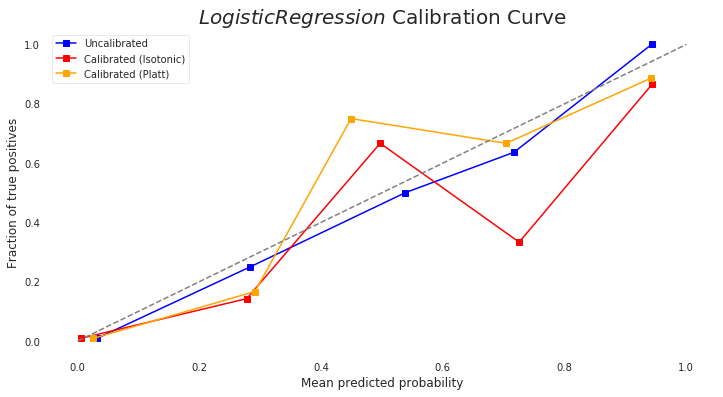

In [21]:
clf = linear_model.LogisticRegression()
clf_isotonic, clf_sigmoid = calibration_plot(clf, train_X, train_y_2, test_X, test_y_2, 5)

The uncalibrated curve seems to be better fitted. The calibrated models have a slightly better accuracy but I think that is just because of some overfitting and since the features of 'Bus' type have little variance (hence the train and test sets have a high correlation).

### Quadratic discriminant analysis

Uncalibrated Test accuracy: 1.0
Calibrated (isotonic) Test accuracy: 1.0
Calibrated (sigmoid) Test accuracy: 1.0


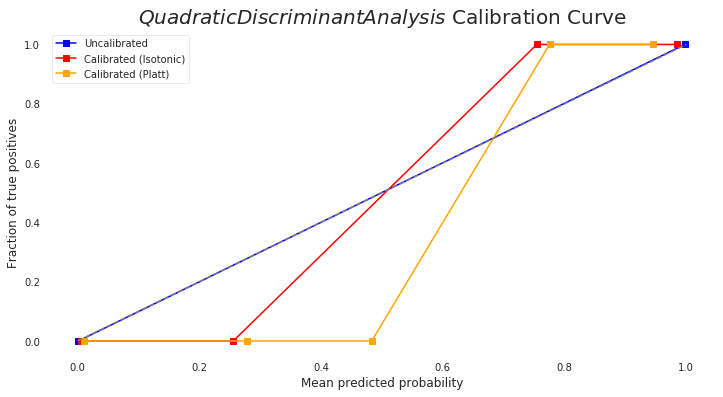

In [22]:
clf = discriminant_analysis.QuadraticDiscriminantAnalysis()
clf_isotonic, clf_sigmoid = calibration_plot(clf, train_X, train_y_2, test_X, test_y_2, 5)

We already knew that QDA is a perfect classifier in this scenario. But it also seems to perfectly predict the probabilities and not just the class. However, if we run this with more bins (eg: 20), it slowly deviates and shifts slightly to the right instead of starting at the origin.

### SVC

Uncalibrated Test accuracy: 0.9823529411764705
Calibrated (isotonic) Test accuracy: 0.9764705882352941
Calibrated (sigmoid) Test accuracy: 0.9823529411764705


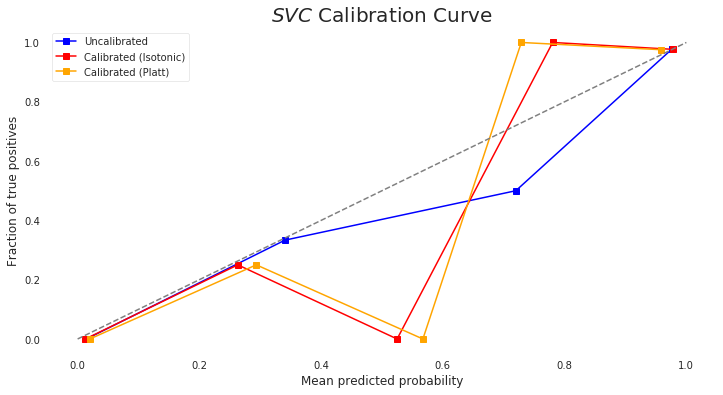

In [23]:
clf = svm.SVC(probability=True)
clf_isotonic, clf_sigmoid = calibration_plot(clf, train_X, train_y_2, test_X, test_y_2, 5)

The uncalibrated classifier gives good results (better than the calibrated ones).

### Naive bayes

Uncalibrated Test accuracy: 0.7823529411764706
Calibrated (isotonic) Test accuracy: 0.8411764705882353
Calibrated (sigmoid) Test accuracy: 0.8294117647058824


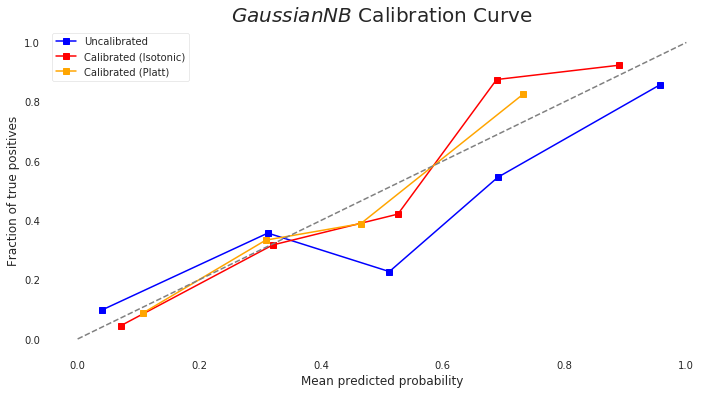

In [24]:
clf = naive_bayes.GaussianNB()
clf_isotonic, clf_sigmoid = calibration_plot(clf, train_X, train_y_2, test_X, test_y_2, 5)

The model seems to be under-confident for the most part due to the presence of redundant features which as I have already mentioned, makes the classifier fit a thin region around the sample space too. However, the calibrated models really increase the performance by a significant amount.

### Random forest

Uncalibrated Test accuracy: 0.9882352941176471
Calibrated (isotonic) Test accuracy: 0.9941176470588236
Calibrated (sigmoid) Test accuracy: 0.9823529411764705


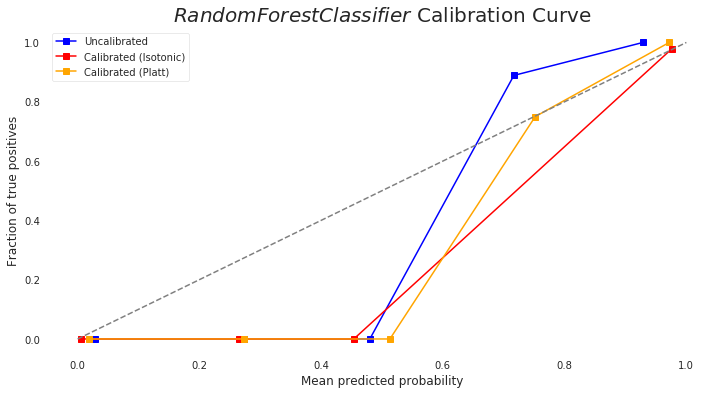

In [25]:
clf = ensemble.RandomForestClassifier()
clf_isotonic, clf_sigmoid = calibration_plot(clf, train_X, train_y_2, test_X, test_y_2, 5)

Though the classifiers are predicting the class alright but they are not optimally confident. Both of the calibrated models are under-confident, which may be due to varying predictions among the individual classifiers of the ensemble.

# Future plans

* Instead of one-vs-all classifiers, the 4 classes can be reduced to 2 classes, for example, we take *bus* and *opel* as one category and *saab* and *van* as another category. It would reduce the data imbalance.
* Check the calibration curve before and after hyper-parameter tuning.